**Téléchargement et installation de CLIP**

In [1]:
! pip install -q ftfy regex tqdm
! pip install -q git+https://github.com/openai/CLIP.git
import clip
import numpy as np

  Preparing metadata (setup.py) ... done


**Montage du drive pour extraire les images médicales**

In [2]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# to mount google drive
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/MyDrive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: google-drive-ocamlfuse: command not found
/content/drive/MyDrive


**Chargement du modèle**

In [3]:
model, preprocess = clip.load('ViT-B/16')

**Sélection manuelle de 8 images et 8 descriptions**

In [4]:
med_descriptions = {
    "ROCO_00247": "Chest radiograph showing no abnormality",
    "ROCO_00077": "Underfilled root canal with void",
    "ROCO_00162": "Biphalangeal fifth toe",
    "ROCO_00166": "CT-Scan with anastomotic lesion.",
    "ROCO_00254": "Postobturation",
    "ROCO_00295": "Metapex intracanal medicament",
    "ROCO_00326": "Mammography showing breast tumor",
    "ROCO_00490": "Gonial angle in lateral cephalometry"
}

**Calcul de la similarité cosine en zero shot dans une matrice 8x8 sur la sélection précédente**

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

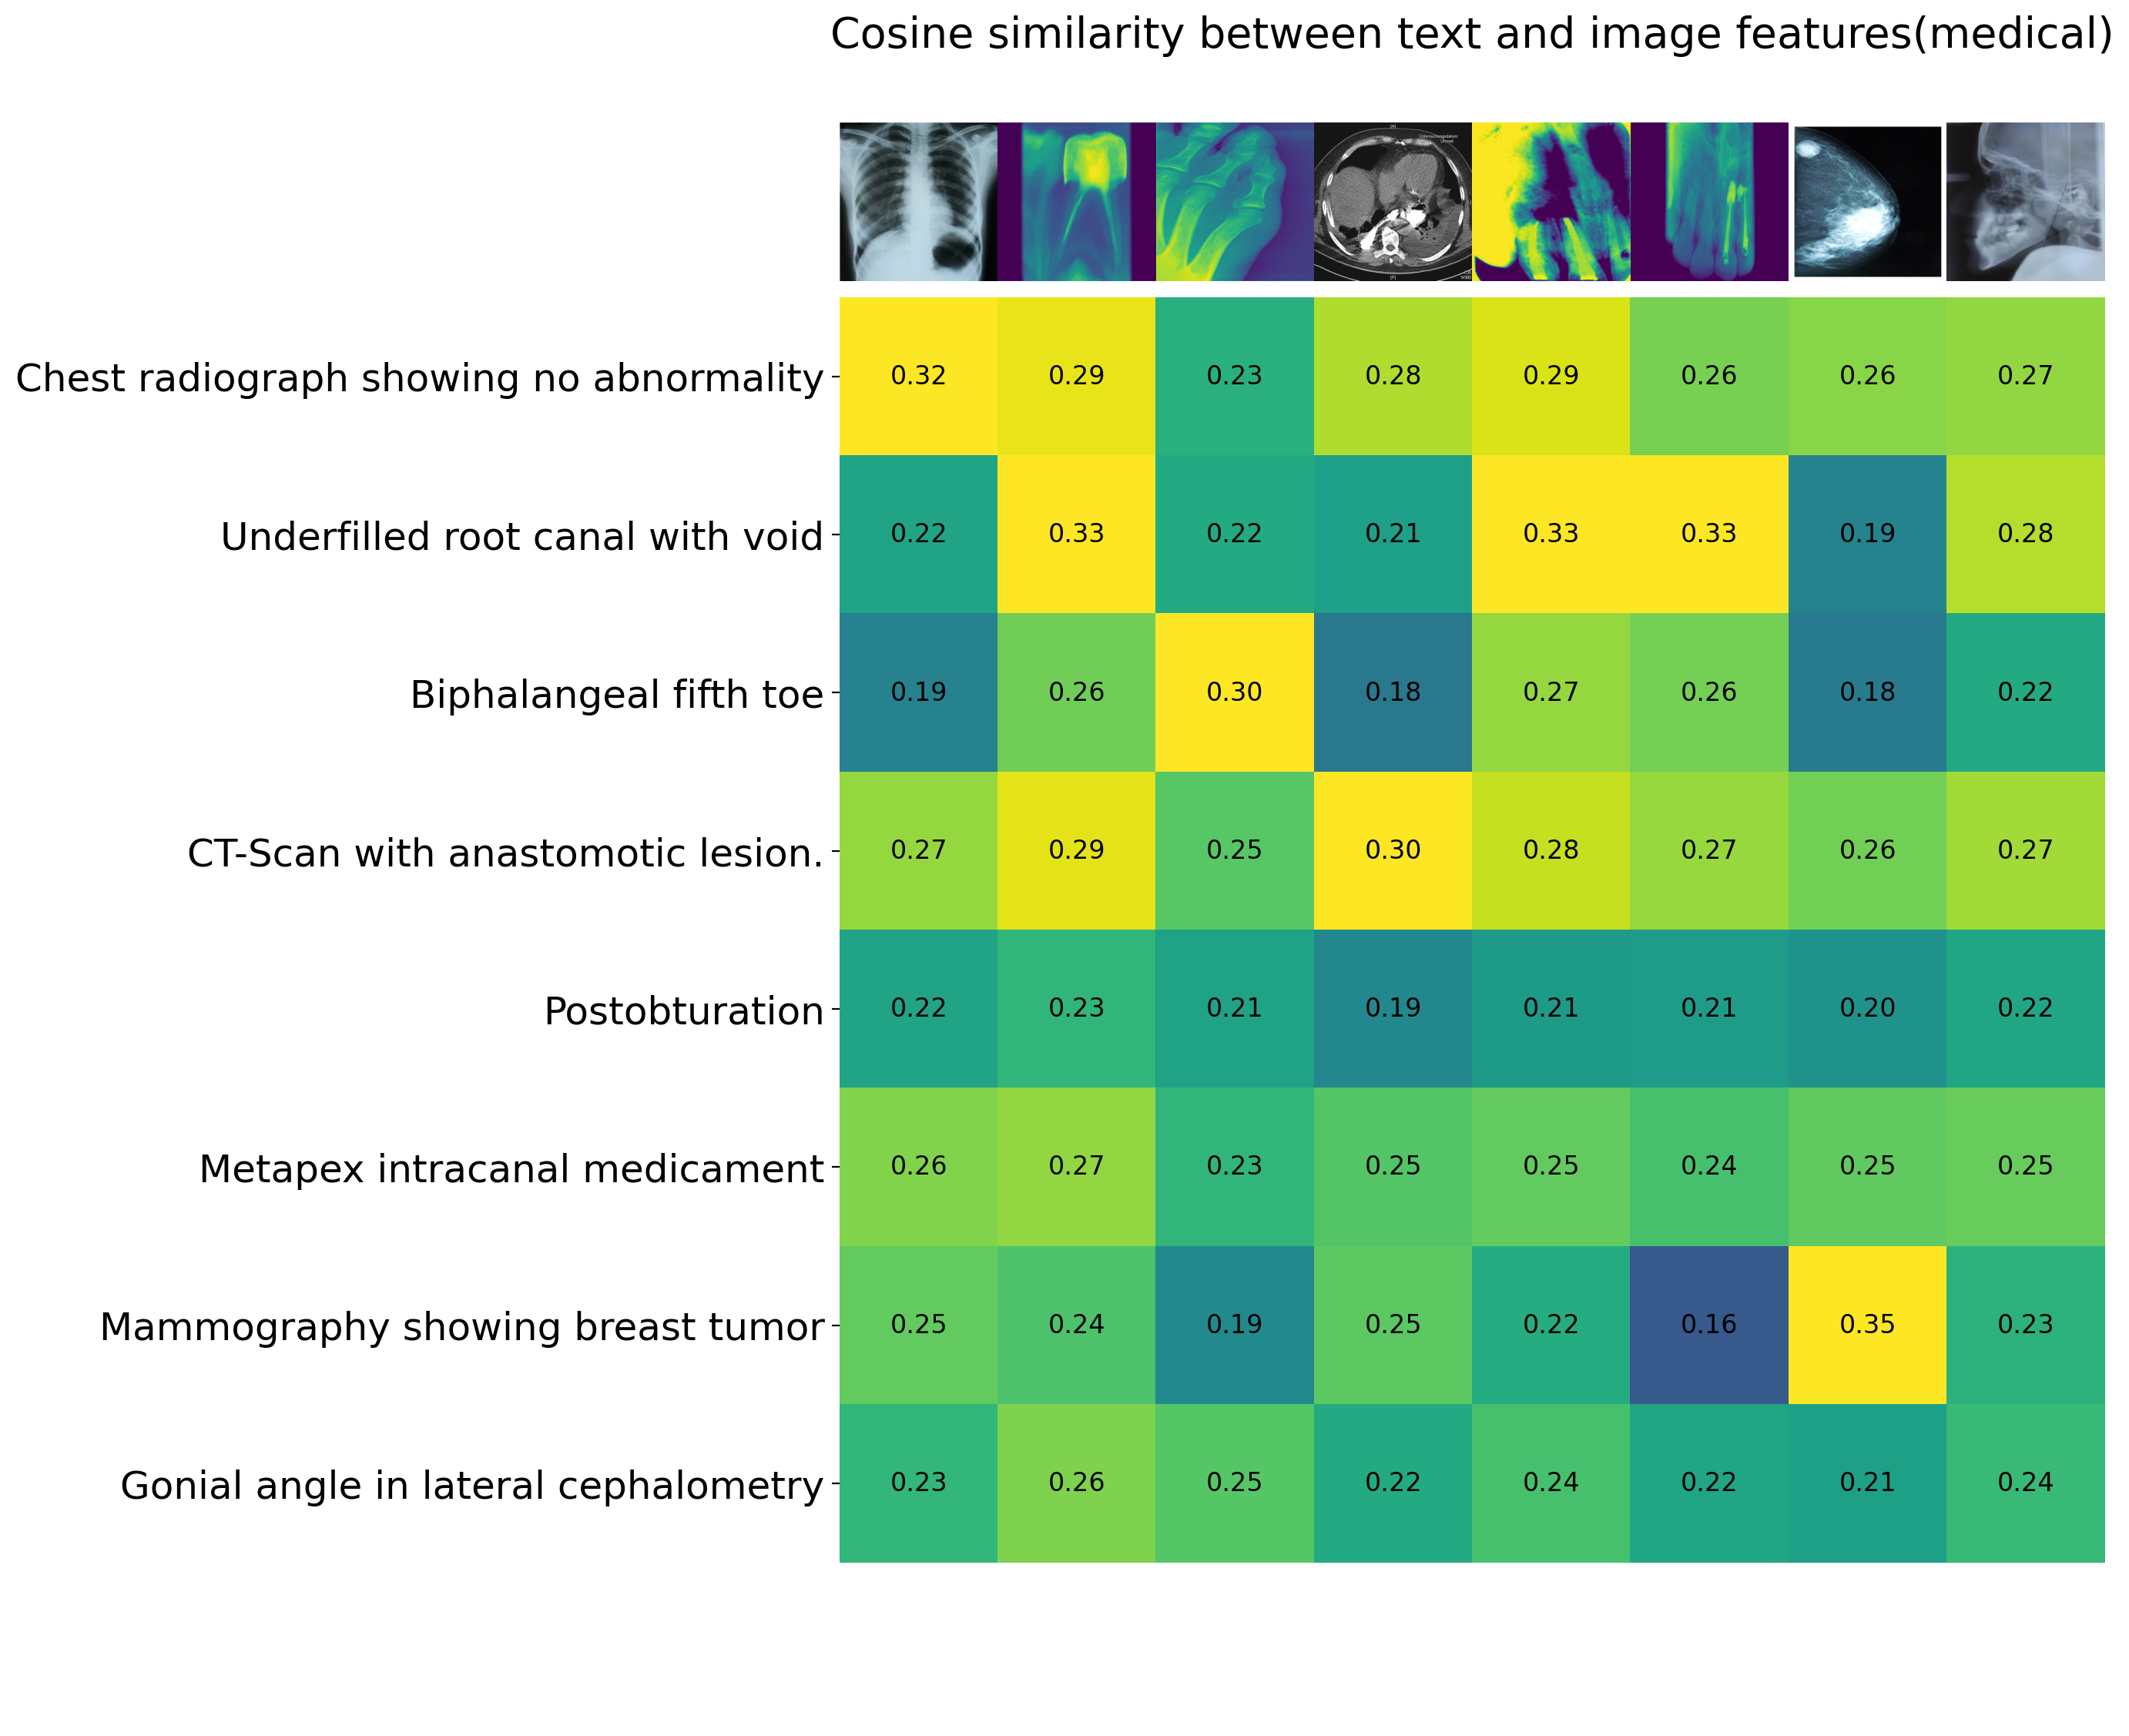

In [6]:
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join("/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/pretrain_data/roco/train/radiology/images", filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is a " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(med_descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)


In [7]:
import gc
gc.collect()

34

**Finetuning du modèle sur 1 epoch (faute de moyens et de temps) pour l'adapter au domaine médical**

In [8]:
# dataset location
csv_file ="/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/roco-list.csv"
root_dir = "/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/pretrain_data/roco/train/radiology/images"
val_csv_file = "/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/local-val-list.csv"
val_root_dir = "/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/pretrain_data/roco/val/radiology/images"

# train options
seed = 42
batch_size = 48
image_size = 224
start_epoch = 0
epochs = 1
visual_encoder = "clip@ViT-B/16"
learning_rate = 3e-6
model_path = "/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/model_checkpoint_CLIP_ROCO_FINAL/" # set to the directory containing `checkpoint_##.tar`


In [9]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import datetime
import time
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import Dataset
import random
import clip



class CLRDataset(Dataset):
    """Contrastive Learning Representations Dataset."""

    def __init__(self, csv_file, root_dir, transform=None, clip=False):
        self.clr_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.clip = clip

    def __len__(self):
        return len(self.clr_frame)

    def text_sampling(self, text):
        text = text.replace("\n", " ")
        text = text.split(".")
        if '' in text:
            text.remove('')
        text = random.choice(text)
        return text

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.clr_frame.iloc[idx, 0]
                                )
        if not os.path.exists(img_name):
            img_name=img_name.replace('train','val')
        image = Image.open(img_name)
        if not self.clip:
            image = image.convert('RGB')
        text = self.clr_frame.iloc[idx, 1]
        name = self.clr_frame.iloc[idx, 0]
        sample = {'image': image, 'text': text,'name':name}
        if self.clip:
            sample = self.transform(sample['image']), sample['text'],sample['name'] #self.text_sampling(sample['text'])
        elif self.transform:
            sample = self.transform(sample)

        return sample


def load_optimizer( model, lr=3e-6):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, epochs, eta_min=0, last_epoch=-1
    )
    return optimizer, scheduler


def train( train_loader, model, tokenizer, optimizer,truncation):
    loss_epoch = 0
    for step, (images, texts,name) in enumerate(train_loader):
        optimizer.zero_grad()
        x_v = images.to('cuda')
        x_u = tokenizer(list(texts), truncate=True).to('cuda')

        v,u=model(x_v,x_u)

        labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

        loss_img = torch.nn.CrossEntropyLoss()
        loss_txt = torch.nn.CrossEntropyLoss()

        img_loss = loss_img(v,labels)
        text_loss = loss_txt(u,labels)

        loss = (img_loss + text_loss)/2

        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")

        loss_epoch += loss.item()
    return loss_epoch



def validate( val_loader, model, tokenizer, optimizer, truncation):

    with torch.no_grad():
        model.eval()
        loss_epoch = 0
        for step, (x_v, x_u,_) in enumerate(val_loader):
            x_v = x_v.to('cuda')
            x_u = tokenizer(list(x_u), truncate=True).to('cuda')

            v,u=model(x_v,x_u)

            labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

            loss_img = torch.nn.CrossEntropyLoss()
            loss_txt = torch.nn.CrossEntropyLoss()

            img_loss = loss_img(v,labels)
            text_loss = loss_txt(u,labels)

            loss = (img_loss + text_loss)/2
            loss_epoch += loss.item()

    model.train()
    return loss_epoch


def main(gpu):

    is_master=True

    # set GPU device
    torch.cuda.set_device(gpu)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # initialize model
    print("Initializing model... ", end="", flush=True)
    model, preprocess = clip.load(visual_encoder.split("@")[-1], device='cuda', jit=False)
    model.float()
    tokenizer=clip.tokenize
    train_fonction = train
    validate_fonction = validate

    # optimizer
    optimizer, scheduler = load_optimizer(model, lr=float(learning_rate))

    # initialize dataloader
    transform = preprocess
    print('Image_Transform',transform)
    train_dataset = CLRDataset(csv_file=csv_file,
                               root_dir=root_dir,
                               transform=transform,
                               clip = True
                               )

    val_dataset = CLRDataset(csv_file=val_csv_file,
                             root_dir=val_root_dir,
                             transform=transform,
                             clip = True
                             )

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        drop_last=True,
        num_workers=8,
        sampler=train_sampler,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=True,
        num_workers=8
    )

    print("[DONE]\n")
    print("STARTING TRAINING")
    print('Start Time =', datetime.datetime.now().strftime("%H:%M:%S"), '\n')

    t0 = time.time()
    global_step = 0
    current_epoch = 0
    best_val_loss = np.inf

    for epoch in range(0, epochs):
        if epoch<2:
            if train_sampler is not None:
                train_sampler.set_epoch(epoch)

            lr = optimizer.param_groups[0]["lr"]
            loss_epoch = train_fonction(train_loader, model, tokenizer, optimizer,True)

        if is_master:
            val_loss = validate_fonction( val_loader, model, tokenizer, optimizer, True)
            if val_loss < best_val_loss:
                torch.save(model.state_dict(), os.path.join(model_path, "best_checkpoint_FINAL.pth"))
                best_val_loss = val_loss

            epoch_counter = epoch - 0
            elapsed = time.time() - t0
            epoch_time = elapsed/(epoch_counter+1)
            remaining = (epochs - (epoch_counter+1))*epoch_time
            remaining = str(datetime.timedelta(seconds=round(remaining)))
            elapsed = str(datetime.timedelta(seconds=round(elapsed)))
            print(f'Epoch {epoch_counter+1}/{epochs} [{elapsed}<{remaining}, {round(epoch_time, 2)}s/epoch] {round((epoch_counter+1)/epochs*100, 1)}% loss: {loss_epoch / len(train_loader)}\t val_loss: {val_loss / len(val_loader)} lr: {lr}')

            current_epoch += 1


if not os.path.exists(model_path):
    os.makedirs(model_path)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
main(0)

Device: cuda:0
Initializing model... Image_Transform Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x781f6b4749d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
[DONE]

STARTING TRAINING
Start Time = 13:21:41 



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step [0/1362]	 Loss: 2.5664572715759277
Step [100/1362]	 Loss: 1.4841476678848267
Step [200/1362]	 Loss: 1.297959566116333
Step [300/1362]	 Loss: 1.6320651769638062
Step [400/1362]	 Loss: 1.2590595483779907
Step [500/1362]	 Loss: 1.301041841506958
Step [600/1362]	 Loss: 1.2205462455749512
Step [700/1362]	 Loss: 0.901500940322876
Step [800/1362]	 Loss: 1.4129258394241333
Step [900/1362]	 Loss: 1.0398199558258057
Step [1000/1362]	 Loss: 0.7150142788887024
Step [1100/1362]	 Loss: 0.9290192127227783
Step [1200/1362]	 Loss: 0.9155998229980469
Step [1300/1362]	 Loss: 0.7036318778991699
Epoch 1/1 [0:53:53<0:00:00, 3233.13s/epoch] 100.0% loss: 1.2246705786859762	 val_loss: 0.9960261513205135 lr: 3e-06


**Second calcul de la similarité cosine après un finetuning de 1 epoch : amélioration des résultats**

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

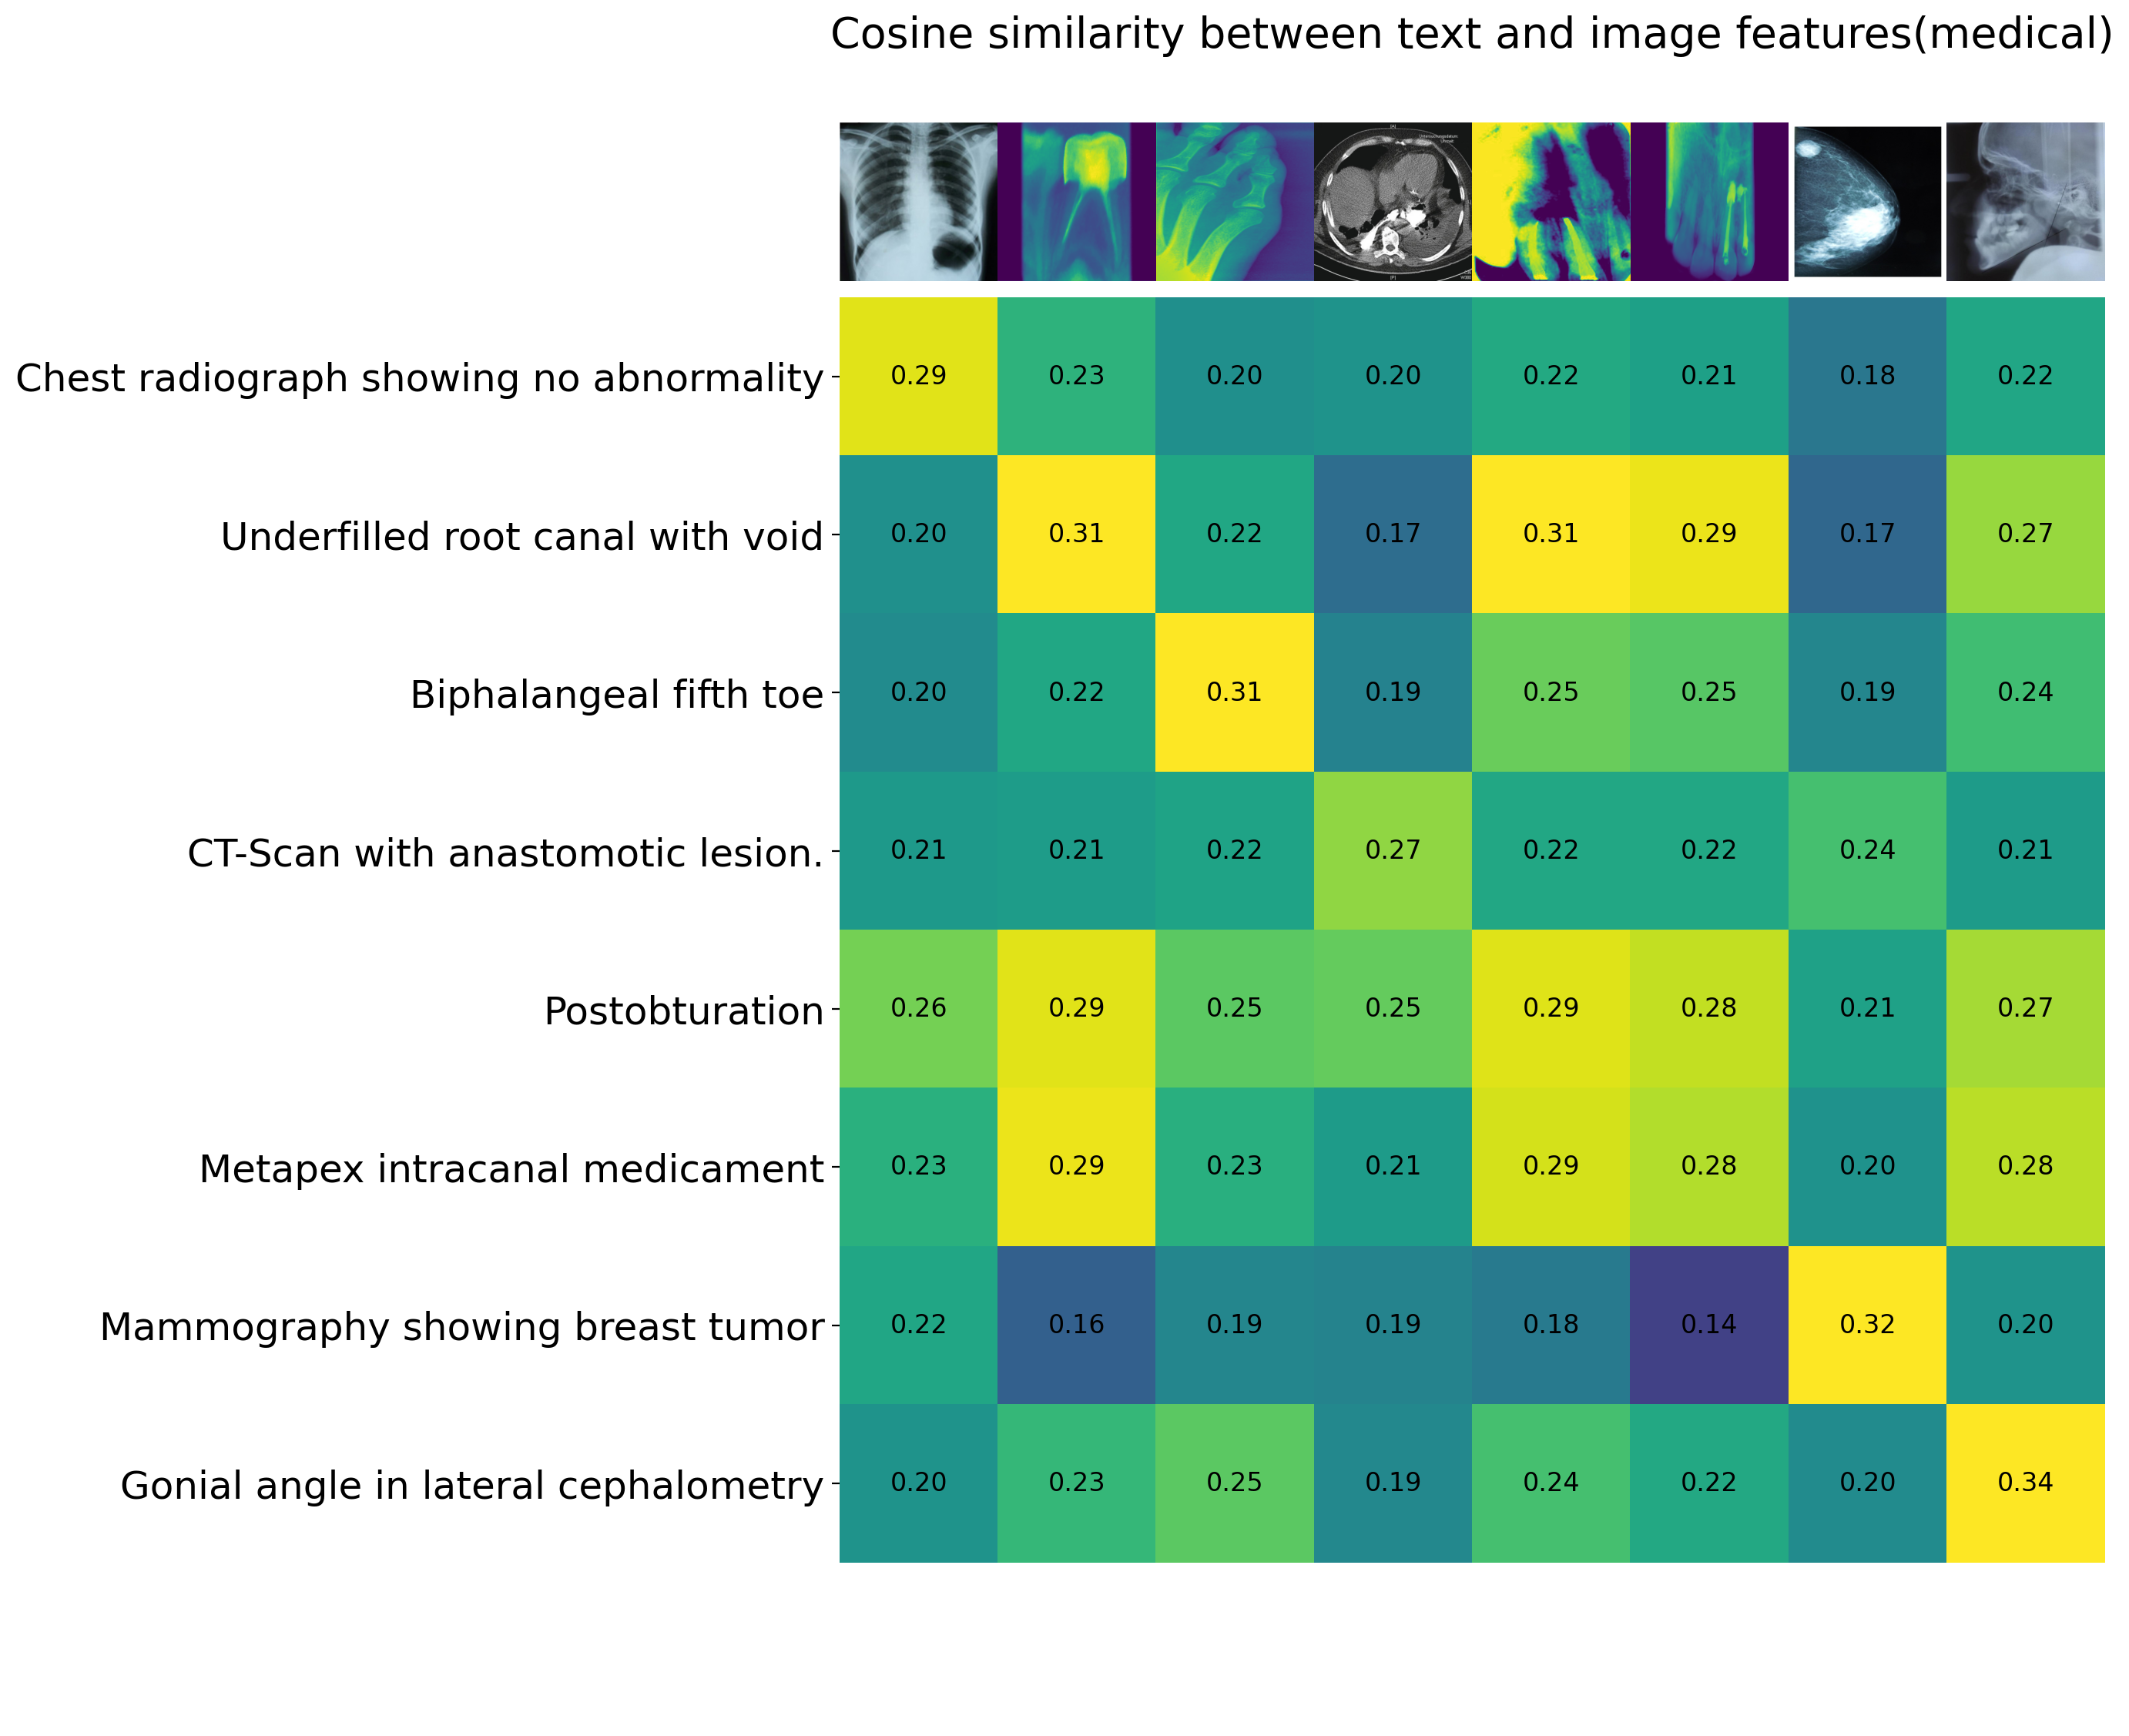

In [11]:
#load checkpoint
model.load_state_dict(torch.load(model_path+"best_checkpoint_FINAL.pth"))

#compute txt-img similarity again
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join(root_dir, filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(med_descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)

**Calcul de la même similarité cosine avec un modèle plus longuement finetuné fourni dans le tp : amélioration des performances par le transfert de connaissances**

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

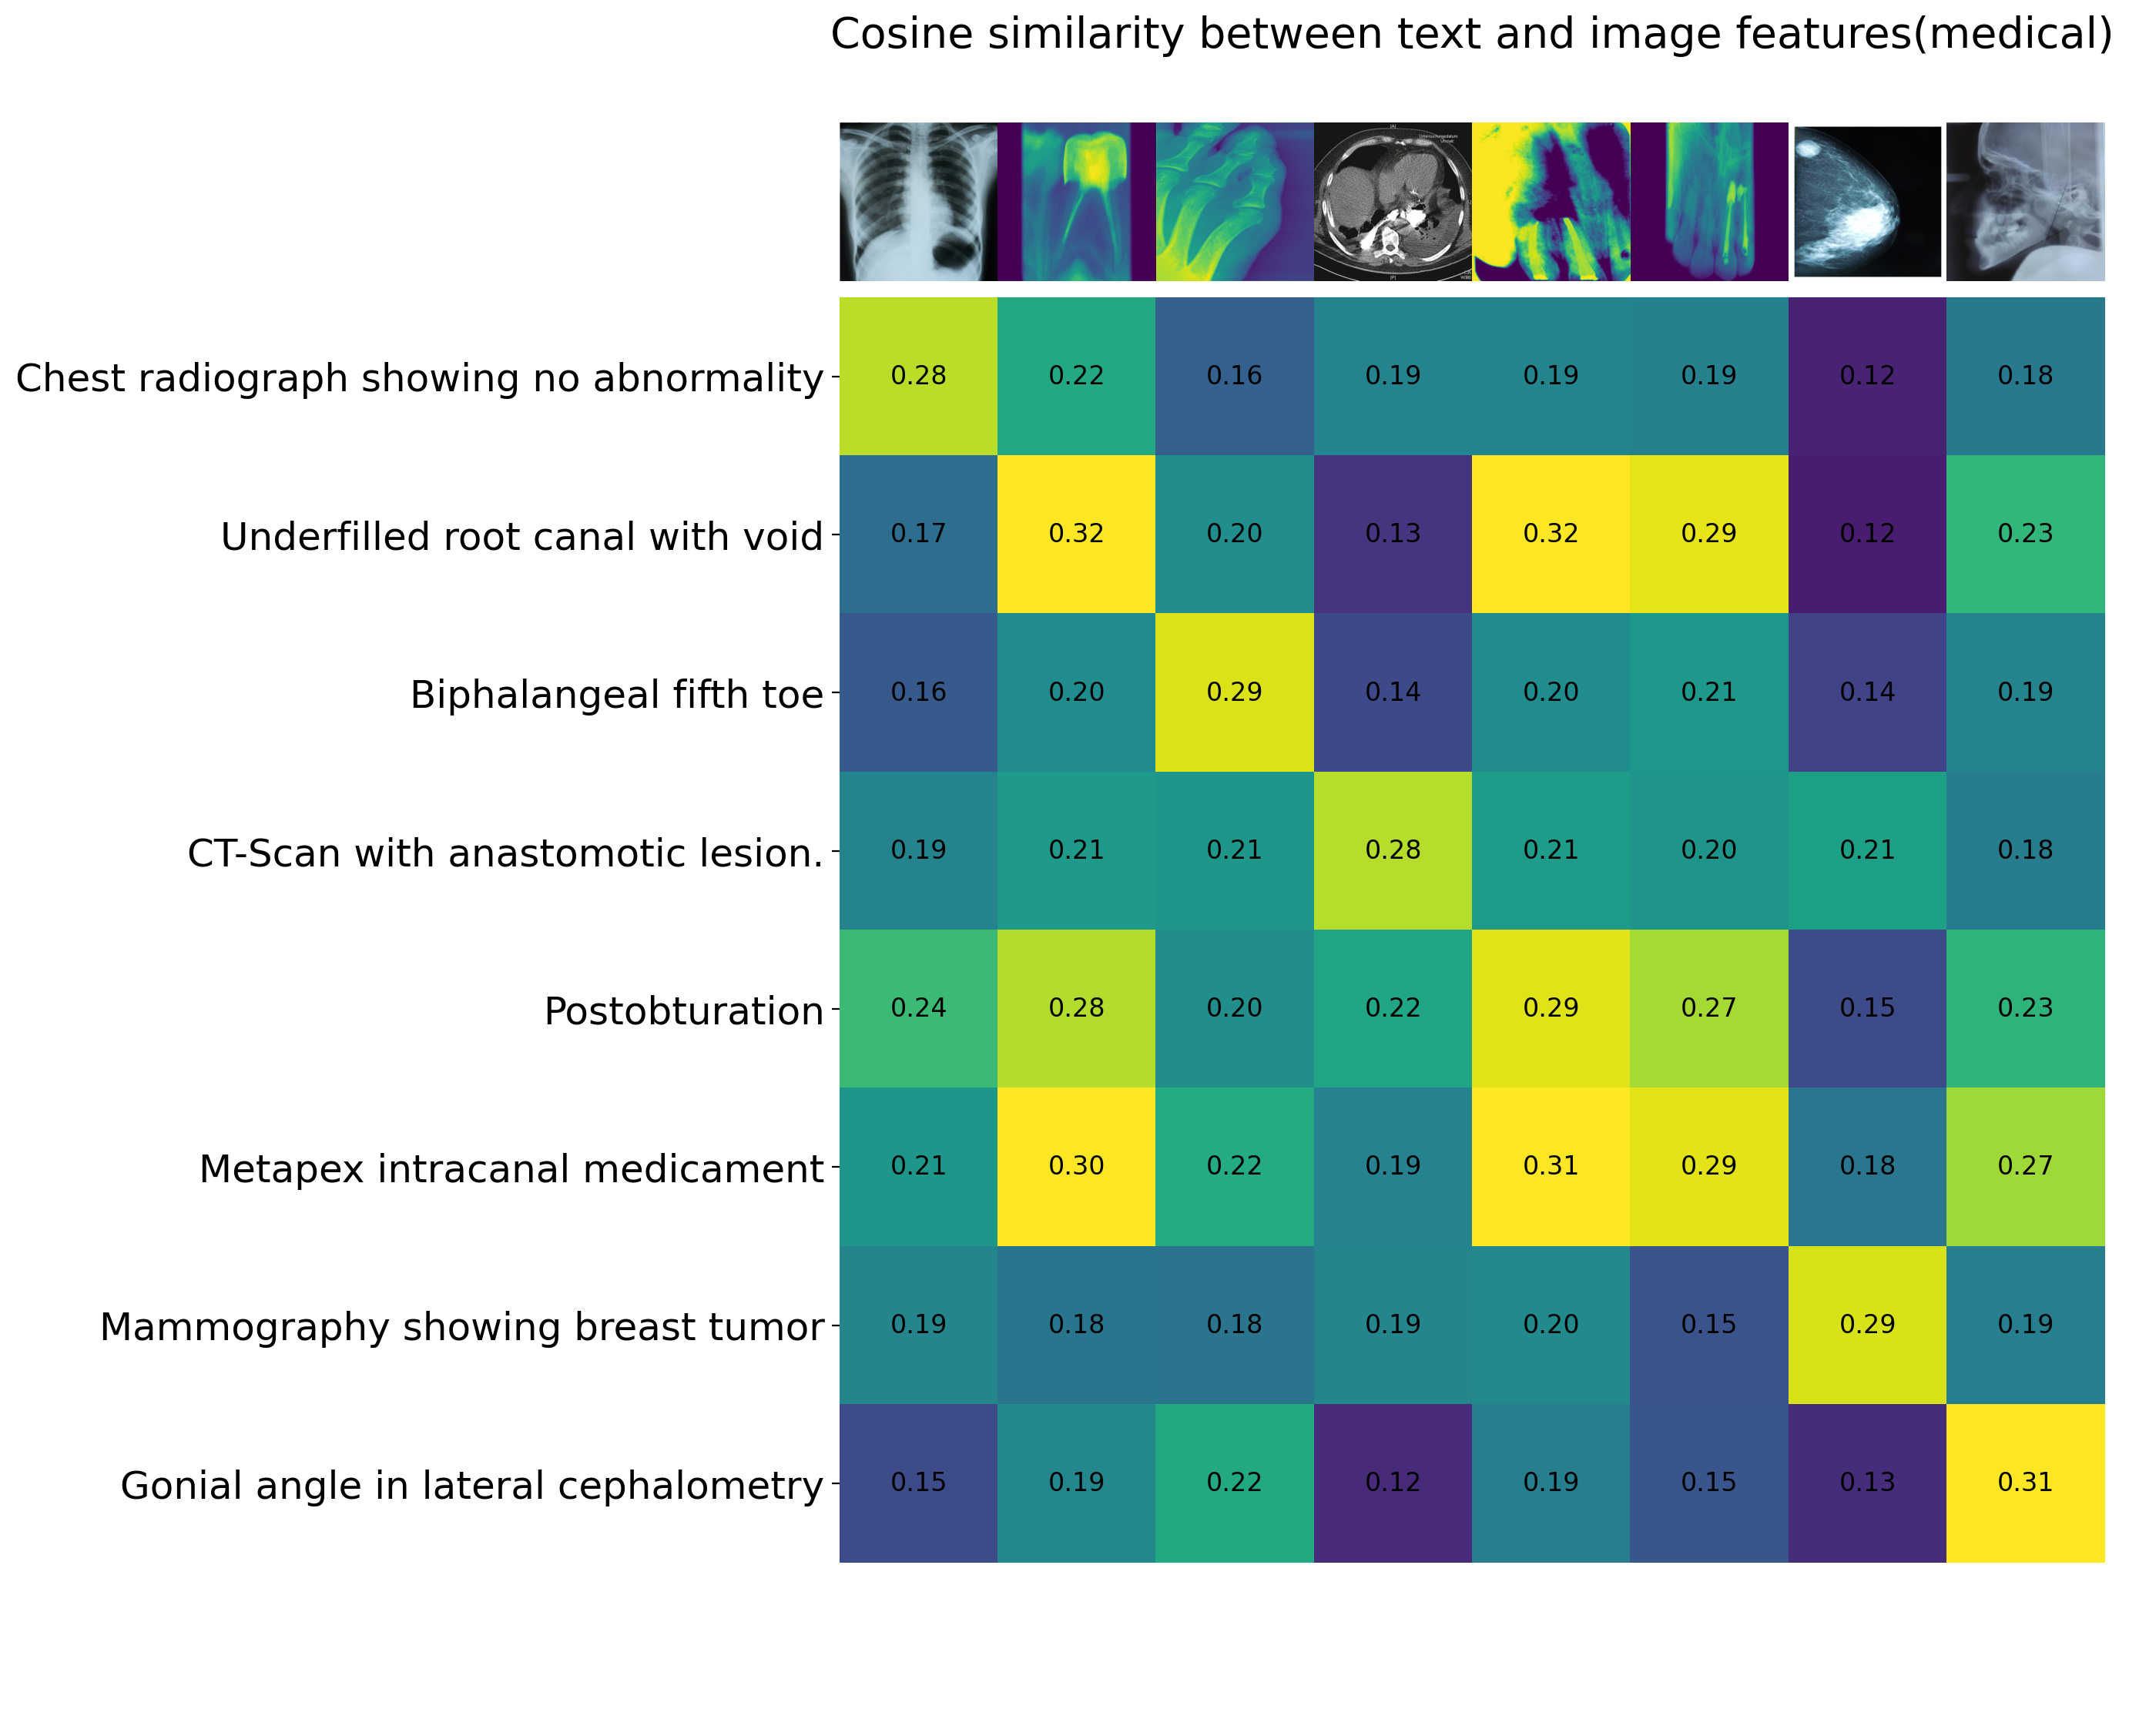

In [12]:
#load checkpoint
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/M2/AIDE_DECISION/data/ViT-B-16_best_checkpoint_2.tar'))

#compute txt-img similarity again
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join(root_dir, filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(med_descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)